# Prediction of Health Measures Based on Location

**Data Scientist:** Elina Rankova

<p align="center">
  <img src="https://media.licdn.com/dms/image/C4D12AQE3ln6Z4Mo8Pw/article-cover_image-shrink_720_1280/0/1642087174753?e=1718236800&v=beta&t=etvT9WV2qS3g7hAnCds-vQIn3ob9JqJn9vvB9annTWM">
</p>
<a href="https://www.linkedin.com/pulse/benefits-population-health-management-phm-amazing-charts/">Image Source</a>

## Business Problem and Understanding

**Stakeholders:** Company executives specializing in operational expansion to improve public health prevention where it is most needed.

As technology evolves, public health and healthcare in particular has long been been lagging behind. In recent years, more companies are leaning on data and technology to inform growth opportunities with the goal of helping those most in need.

As an independent contractor specializing in expanding resource availability to undeserved populations, this project aims to identify overall health disparity across the United States utilizing public county and census data provided by the CDC. Proving population health measure specifics based on an overall Health Disparity Index can help direct those striving to close care gaps to expand where there is the greatest need.

For Phase 1 of this initiative we will define a Health Disparity Index (HDI) based on a number of health measures and population by geolocation.

**The goal:** Provide clients with a holistic understanding of the measures contributing to an overall Health Disparity Index aggregated by geolocation to better understand what United States regions most provide opportunity for growth.

In [70]:
# Import libraries
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import random
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.base import clone
from src.metrics_cv import MetricsCV
import pickle
import warnings
warnings.filterwarnings("ignore")

## Data Understanding

For this task we will be using CDC provided PLACES and SDOH county data spanning years 2017-2021
Datasets
- <a href="https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-County-Data-20/dv4u-3x3q/about_data">Local Data for Better Health, County Data 2020 release</a>
- <a href="https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-County-Data-20/pqpp-u99h/about_data">Local Data for Better Health, County Data 2021 release</a>
- <a href="https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-County-Data-20/duw2-7jbt/about_data">Local Data for Better Health, County Data 2022 release</a>
- <a href="https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-County-Data-20/swc5-untb/about_data">Local Data for Better Health, County Data 2023 release</a>
- <a href="https://data.cdc.gov/500-Cities-Places/SDOH-Measures-for-County-ACS-2017-2021/i6u4-y3g4/about_data">SDOH Measures for County, ACS 2017-2021</a>

Utilizing all the health measures defined within the cagtegories specified below we will create a custom Health Disparity Index (HDI) as our target for this regression task.

**Categories within which health measures are defined:** Health Outcomes, Prevention, Health Risk Behaviors, Health Status, Disabilities, and Social Determinants of Health

In [71]:
# Load datasets

pl1 = pd.read_csv('data/PLACES_2017-2018.csv')
pl2 = pd.read_csv('data/PLACES_2018-2019.csv')
pl3 = pd.read_csv('data/PLACES_2019-2020.csv')
pl4 = pd.read_csv('data/PLACES_2020-2021.csv')
sdoh = pd.read_csv('data/SDOH_2017-2021.csv')

We may want to check on the `StateAbbr` and `StateDesc` since it's showing the country in the preview. We also want to adjust the LocationName to either exclude 'county' or include 'county' to make sure both of the datasets are aligned in nomenclature.

Since the data we are working with is by county, we can eliminate the added specification with the `LocationName` in the SDOH dataset.

We will also have to deal with the differences in the `Year` column since it is an object and range in the SDOH data and an integer in the PLACES data.

In [3]:
# Concat all PLACES datasets
pl_all = pd.concat([pl1, pl2, pl3, pl4])
display(pl_all.tail())

sdoh.head()

,Year,StateAbbr,StateDesc,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,...,High_Confidence_Limit,TotalPopulation,Latitude,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text,Geolocatioin,LocationID,Geolocation
228765,2021,TX,Texas,Brown,BRFSS,Health Outcomes,High cholesterol among adults aged >=18 years ...,%,Crude prevalence,40.4,...,45.5,38192,NaN,HLTHOUT,HIGHCHOL,CrdPrv,High Cholesterol,NaN,48049.0,POINT (-98.998456 31.7641372)
228766,2021,TX,Texas,Grayson,BRFSS,Health Outcomes,Chronic kidney disease among adults aged >=18 ...,%,Age-adjusted prevalence,2.8,...,3.2,139336,NaN,HLTHOUT,KIDNEY,AgeAdjPrv,Chronic Kidney Disease,NaN,48181.0,POINT (-96.675693 33.624524)
228767,2021,SC,South Carolina,Richland,BRFSS,Health Risk Behaviors,No leisure-time physical activity among adults...,%,Crude prevalence,23.9,...,27.5,418307,NaN,RISKBEH,LPA,CrdPrv,Physical Inactivity,NaN,45079.0,POINT (-80.8980371 34.0290952)
228768,2021,WA,Washington,Franklin,BRFSS,Disability,Independent living disability among adults age...,%,Crude prevalence,8.4,...,9.8,98268,NaN,DISABLT,INDEPLIVE,CrdPrv,Independent Living Disability,NaN,53021.0,POINT (-118.9038912 46.5375019)
228769,2020,WI,Wisconsin,La Crosse,BRFSS,Health Outcomes,All teeth lost among adults aged >=65 years,%,Crude prevalence,8.1,...,11.8,120433,NaN,HLTHOUT,TEETHLOST,CrdPrv,All Teeth Lost,NaN,55063.0,POINT (-91.1117584 43.9082222)


,Year,StateAbbr,StateDesc,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,MOE,TotalPopulation,LocationID,CategoryID,MeasureID,DataValueTypeID,Short_Question_Text,Geolocation
0,2017-2021,AL,Alabama,Coosa County,5-year ACS,SDOH,Housing cost burden among households,%,Percentage,12.8,4.0,10442,1037,SDOH,HCOST,Percent,Housing cost burden,POINT (-86.2434818 32.9314453)
1,2017-2021,AL,Alabama,Lamar County,5-year ACS,SDOH,Persons living below 150% of the poverty level,%,Percentage,27.4,4.0,13929,1075,SDOH,POV150,Percent,Poverty,POINT (-88.0874309 33.7870852)
2,2017-2021,AK,Alaska,Aleutians East Borough,5-year ACS,SDOH,Crowding among housing units,%,Percentage,4.6,2.3,3409,2013,SDOH,CROWD,Percent,Crowding,POINT (-161.9974772 55.2450437)
3,2017-2021,AR,Arkansas,Dallas County,5-year ACS,SDOH,Crowding among housing units,%,Percentage,2.3,2.2,6645,5039,SDOH,CROWD,Percent,Crowding,POINT (-92.6539989 33.9678233)
4,2017-2021,AR,Arkansas,Franklin County,5-year ACS,SDOH,Crowding among housing units,%,Percentage,2.6,1.8,17159,5047,SDOH,CROWD,Percent,Crowding,POINT (-93.8876647 35.5085579)


In [4]:
# Lowercase all data to ensure consistency
sdoh = sdoh.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
pl_all = pl_all.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# Delete the 'county, burough, census area' specification and any white space
sdoh['LocationName'] = sdoh['LocationName'].str.replace(r'\s*(county|borough|census area)\s*','', regex=True)

In [5]:
sdoh['LocationName']

0                 coosa
1                 lamar
2        aleutians east
3                dallas
4              franklin
              ...      
28282           swisher
28283       greensville
28284              clay
28285              jack
28286             hardy
Name: LocationName, Length: 28287, dtype: object

In [6]:
print(sdoh.info())
print(pl_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28287 entries, 0 to 28286
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 28287 non-null  object 
 1   StateAbbr            28287 non-null  object 
 2   StateDesc            28287 non-null  object 
 3   LocationName         28278 non-null  object 
 4   DataSource           28287 non-null  object 
 5   Category             28287 non-null  object 
 6   Measure              28287 non-null  object 
 7   Data_Value_Unit      28287 non-null  object 
 8   Data_Value_Type      28287 non-null  object 
 9   Data_Value           28287 non-null  float64
 10  MOE                  28285 non-null  float64
 11  TotalPopulation      28287 non-null  int64  
 12  LocationID           28287 non-null  int64  
 13  CategoryID           28287 non-null  object 
 14  MeasureID            28287 non-null  object 
 15  DataValueTypeID      28287 non-null 

We will have to drop `Low_Confidence_Limit` and `High_Confidence_Limit` since the SDOH dataset does not have these columns.

In [7]:
print(sdoh.isna().sum()/sdoh.shape[0],'\n')
print(pl_all.isna().sum()/pl_all.shape[0])

Year                   0.000000
StateAbbr              0.000000
StateDesc              0.000000
LocationName           0.000318
DataSource             0.000000
Category               0.000000
Measure                0.000000
Data_Value_Unit        0.000000
Data_Value_Type        0.000000
Data_Value             0.000000
MOE                    0.000071
TotalPopulation        0.000000
LocationID             0.000000
CategoryID             0.000000
MeasureID              0.000000
DataValueTypeID        0.000000
Short_Question_Text    0.000000
Geolocation            0.000318
dtype: float64 

Year                          0.000000
StateAbbr                     0.000000
StateDesc                     0.000000
LocationName                  0.000320
DataSource                    0.000000
Category                      0.000000
Measure                       0.000000
Data_Value_Unit               0.000000
Data_Value_Type               0.000000
Data_Value                    0.000000
Data_Value_Footno

In [8]:
# Merge all datasets together
df_all = pd.concat([pl_all, sdoh])

Right away we can tell that there are a few columns that are missing too many values and will need to be dropped.
- `Data_Value_Footnote_Symbol`
- `Data_Value_Footnote`
- `Latitude`
- `MOE`

`Geolocatioin` and `Geolocation` are the same feature when checking the source data websites only the 2020 release has a `Geolocatioin` column while the rest have `Geolocation`. `MeasureID` and `MeasureId` have the same issue it seems.

There are object type columns that will need to be transformed. Since state should be treated as a categorical variable we should adjust this in our dataset.

In addition, we would also want to make `LocationID` an object since this is not an actual continuous variable.

In [9]:
print(df_all.info(),'\n')

# Drop unneeded columns
df_all.drop(columns=['Data_Value_Footnote_Symbol','Data_Value_Footnote','Latitude',
                     'MOE','Low_Confidence_Limit','High_Confidence_Limit'],inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 809177 entries, 0 to 28286
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Year                        809177 non-null  object 
 1   StateAbbr                   809177 non-null  object 
 2   StateDesc                   809177 non-null  object 
 3   LocationName                808918 non-null  object 
 4   DataSource                  809177 non-null  object 
 5   Category                    809177 non-null  object 
 6   Measure                     809177 non-null  object 
 7   Data_Value_Unit             809177 non-null  object 
 8   Data_Value_Type             809177 non-null  object 
 9   Data_Value                  809177 non-null  float64
 10  Data_Value_Footnote_Symbol  0 non-null       float64
 11  Data_Value_Footnote         0 non-null       float64
 12  Low_Confidence_Limit        780890 non-null  float64
 13  High_Confidence_Limi

We can drop the misspelled `Geolocatioin` after filling in the nas in `Geolocation`. This concept applies to `MeasureID` and `MeasureId` as well.

In [10]:
# Fill NaNs in Geolocation and with Geolocatioin
df_all.loc[df_all['Geolocation'].isna(), 'Geolocation'] = df_all.loc[df_all['Geolocation'].isna(), 'Geolocatioin']

# Apply the same method to `MeasureID
df_all.loc[df_all['MeasureID'].isna(), 'MeasureID'] = df_all.loc[df_all['MeasureID'].isna(), 'MeasureId']

# Drop unneeded columns
df_all.drop(columns=['MeasureId','Geolocatioin'],axis=1,inplace=True)

df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 809177 entries, 0 to 28286
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Year                 809177 non-null  object 
 1   StateAbbr            809177 non-null  object 
 2   StateDesc            809177 non-null  object 
 3   LocationName         808918 non-null  object 
 4   DataSource           809177 non-null  object 
 5   Category             809177 non-null  object 
 6   Measure              809177 non-null  object 
 7   Data_Value_Unit      809177 non-null  object 
 8   Data_Value_Type      809177 non-null  object 
 9   Data_Value           809177 non-null  float64
 10  TotalPopulation      809177 non-null  int64  
 11  CategoryID           809177 non-null  object 
 12  DataValueTypeID      809177 non-null  object 
 13  Short_Question_Text  809177 non-null  object 
 14  LocationID           633169 non-null  float64
 15  Geolocation          80

We can drop nas in any columns we are not already dropping such as `LocationName` and the updated `Geolocation`. `LocationID` refers to the FIPcode for the county so we should first see if we can impute with the proper FIPcode before droping nas.

In [11]:
print(df_all.isna().sum()/df_all.shape[0])

df_all.dropna(subset=['LocationName','Geolocation'],inplace=True)

Year                   0.000000
StateAbbr              0.000000
StateDesc              0.000000
LocationName           0.000320
DataSource             0.000000
Category               0.000000
Measure                0.000000
Data_Value_Unit        0.000000
Data_Value_Type        0.000000
Data_Value             0.000000
TotalPopulation        0.000000
CategoryID             0.000000
DataValueTypeID        0.000000
Short_Question_Text    0.000000
LocationID             0.217515
Geolocation            0.000320
MeasureID              0.000000
dtype: float64


Looks like we were able to fill the nas using the associated `LocationID` with existing `Geolocation` as a unique identifier for the FIPcode. 

In [12]:
# Filter rows with non-null LocationID
loc_df = df_all.loc[df_all['LocationID'].notna(), ['Geolocation', 'LocationID']]

# Create LocationName <> LocationID dictionary
loc_dict = dict(zip(loc_df['Geolocation'], loc_df['LocationID']))

# Fill missing LocationID values based on LocationName from the dictionary
df_all['LocationID'] = df_all['LocationID'].fillna(df_all['Geolocation'].map(loc_dict))

# Drop the rest of the nas in LocationID
df_all.dropna(inplace=True)

# Check the percentage of missing values in df_all after filling missing values
print(df_all.isna().sum() / df_all.shape[0])

Year                   0.0
StateAbbr              0.0
StateDesc              0.0
LocationName           0.0
DataSource             0.0
Category               0.0
Measure                0.0
Data_Value_Unit        0.0
Data_Value_Type        0.0
Data_Value             0.0
TotalPopulation        0.0
CategoryID             0.0
DataValueTypeID        0.0
Short_Question_Text    0.0
LocationID             0.0
Geolocation            0.0
MeasureID              0.0
dtype: float64


In [13]:
# Convert 'StateAbbr' and 'LocationID' columns to appropriate type
df_all['StateAbbr'] = df_all['StateAbbr'].astype('category')
df_all['LocationID'] = df_all['LocationID'].astype('str')

# Delete the last two characters from `LocationID' to refject 5 digit FIPcode
df_all['LocationID'] = df_all['LocationID'].str.replace(r'\.0$','',regex=True)
df_all[['LocationID']].head()

,LocationID
49,1001
50,1001
51,1005
52,20115
53,20141


### Feature Exploration

<ins>**Observations**</ins>

- We will likely drop `Year` as it can only provide relevant information for the data we retrieved from the PLACES datasets. Otherwise, we have the same date range as seen in the added SDOH data (2017-2021).
- Looks like we may want to drop the rows with US as the state as it is an error. We can also drop `StateDesc` since it's the same info as `StateAbbr`.
- `DataSource` can be dropped since all of the information is coming from the Behavioral Risk Factor Surveillance System or the 5-year American Community Survey which only contains SDOH data.
- `Data_Value_Unit` can be dropped since all of our data values are in percentages.
- `Data_Value_Type` will be helpful for interpretation of our predictions since it denotes what percentage the `Data_Value` represents. `DataValueTypeID` corresponds to this feature and can be dropped since `Data_Value_Type` is more informative. 
- `CategoryID` corresponds to `Category` so we can drop it since `Category` is easier to interpret.
- `MeasureId` corresponds the same way to `Measure`. However `Measure` values can be quite lengthy depending on the measure. We also have `Short_Question_Text` corresponding to these features and is more informative than `MeausureId` but shorter than `Measure` so we will keep `Short_Question_Text` and create a reference dictionary before dropping the other columns.

In [14]:
print(df_all['Year'].value_counts(),'\n')
print(df_all['StateAbbr'].value_counts(),'\n')
print(df_all['DataSource'].value_counts(),'\n')
print(df_all['Data_Value_Unit'].value_counts(),'\n')
print(df_all['Data_Value_Type'].value_counts(),'\n')
print(df_all['CategoryID'].value_counts(),'\n')
print(df_all['MeasureID'].value_counts(),'\n')
print(df_all['DataValueTypeID'].value_counts(),'\n')
print(df_all['Short_Question_Text'].value_counts(),'\n')

Year
2020         213724
2018         201040
2021         178408
2019         162284
2017-2021     28278
2017          25128
Name: count, dtype: int64 

StateAbbr
tx    65786
ga    41181
va    34391
ky    31080
mo    29785
ks    27195
il    26418
nc    25900
ia    25641
tn    24605
ne    24087
in    23828
oh    22792
mn    22533
mi    21497
ms    21238
ok    19943
ar    19425
wi    18648
al    17353
pa    17353
sd    17094
la    16576
co    16576
ny    16058
ca    15022
mt    14504
wv    14245
nd    13727
fl    13467
sc    11914
id    11396
wa    10101
or     9324
nm     8547
ak     7638
ut     7511
md     6216
wy     5957
nv     4403
nj     4347
me     4144
az     3885
ma     3626
vt     3626
nh     2590
ct     2072
ri     1295
hi     1286
de      777
dc      259
Name: count, dtype: int64 

DataSource
brfss         780584
5-year acs     28278
Name: count, dtype: int64 

Data_Value_Unit
%    808862
Name: count, dtype: int64 

Data_Value_Type
crude prevalence           390292
age-adjust

In [15]:
# Create reference dictionary for category and measure
measure_df = df_all[['Short_Question_Text','Measure','MeasureID']]
measure_reference = measure_df.set_index('MeasureID').drop_duplicates()
category_df = df_all[['Category','CategoryID']]
category_reference = category_df.drop_duplicates()

# Save measure category and measure references
category_reference.to_csv('data/category_reference.csv')
measure_reference.to_csv('data/measure_reference.csv')

In [16]:
# Drop rows with US as state
df_all = df_all.loc[df_all['StateAbbr'] != 'US']

# Drop other relevant columns
df_all.drop(columns=['DataSource','Data_Value_Unit','CategoryID','DataValueTypeID',
                     'StateDesc', 'MeasureID','Year','Measure'],inplace=True)
df_all.columns

Index(['StateAbbr', 'LocationName', 'Category', 'Data_Value_Type',
       'Data_Value', 'TotalPopulation', 'Short_Question_Text', 'LocationID',
       'Geolocation'],
      dtype='object')

Let's quickly check for duplicates since we had to download all of the PLACES datasets separately to accomodate the year range in the SDOH dataset.

In [17]:
dups = df_all.duplicated()
dups.value_counts()

False    808694
True        168
Name: count, dtype: int64

In [18]:
# Drop identified duplicates
df_all.drop_duplicates(ignore_index=True, inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808694 entries, 0 to 808693
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            808694 non-null  category
 1   LocationName         808694 non-null  object  
 2   Category             808694 non-null  object  
 3   Data_Value_Type      808694 non-null  object  
 4   Data_Value           808694 non-null  float64 
 5   TotalPopulation      808694 non-null  int64   
 6   Short_Question_Text  808694 non-null  object  
 7   LocationID           808694 non-null  object  
 8   Geolocation          808694 non-null  object  
dtypes: category(1), float64(1), int64(1), object(6)
memory usage: 50.1+ MB


### Statistical Analysis

Before we move onto defining the target, we should look at the numerical distribution of the `Data_Value` and `TotalPopulation` columns. 

We can see there are some outliers in both columns we should consider visualizing and potentially dropping to get a more accurate representation of our distributions.

We will want to consider normalizing the `Data_Value` column since the values are represented differently based on type. We can also consider weighing it if we consider one type more important than another.

In [19]:
df_all[['Data_Value','TotalPopulation']].describe()

,Data_Value,TotalPopulation
count,808694.000000,8.086940e+05
mean,30.404016,1.033569e+05
std,24.766709,3.318928e+05
min,0.000000,5.700000e+01
25%,10.700000,1.080600e+04
50%,22.100000,2.562900e+04
75%,40.200000,6.749000e+04
max,99.400000,1.010552e+07


When visualizing these features, we can estimate that any `Data_Value` above ~85 is an outlier. It is harder to determine for `TotalPopulation`. We should look at the values of these more closely.

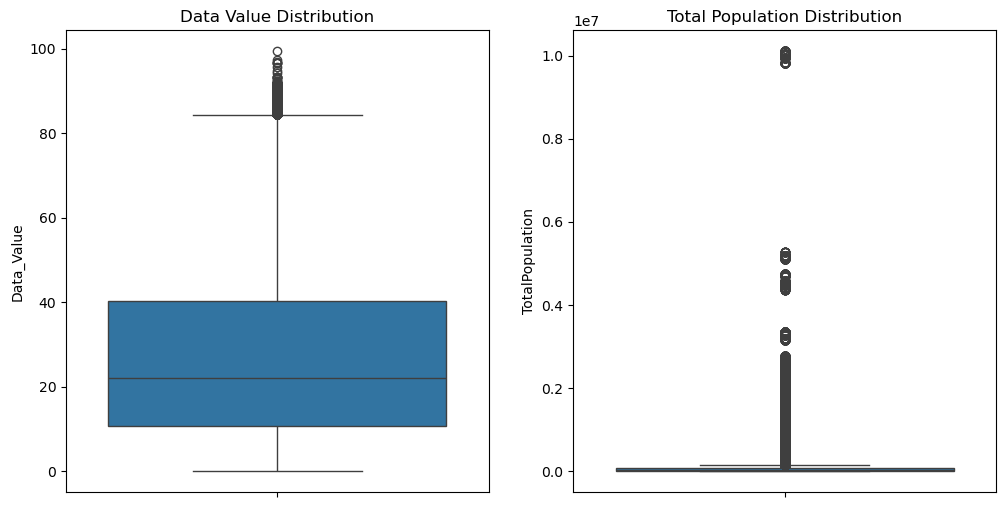

In [20]:
fig, ax = plt.subplots(ncols=2,figsize=(12,6))
sns.boxplot(df_all['Data_Value'],ax=ax[0])
ax[0].set_title('Data Value Distribution')

sns.boxplot(df_all['TotalPopulation'],ax=ax[1])
ax[1].set_title('Total Population Distribution');

Taking closer at the number of rows that are outside of the the IQR, there are quite a few rows with population and data value outside of bounds.

In [21]:
for col in df_all[['TotalPopulation', 'Data_Value']].columns:
    Q1 = df_all[col].quantile(.25)
    Q3 = df_all[col].quantile(.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_all[(df_all[col] < lower_bound) | (df_all[col] > upper_bound)]
    print(f'{col} outliers:',outliers.shape[0])

TotalPopulation outliers: 111425
Data_Value outliers: 15851


Double checking each data type to see if they behave differently in relation to it's own data type vs collectively we see there is indeed a difference.

In [22]:
total_outliers = 0
outlier_info = []
for data, data_type in [('Data_Value', 'Data_Value_Type')]:
    # IQR for 'Data_Value' filtered by 'Data_Value_Type'
    grouped = df_all.groupby(data_type)
    for name, group in grouped:
        Q1 = group[data].quantile(0.25)
        Q3 = group[data].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Detecting outliers
        outliers = group[(group[data] < lower_bound) | (group[data] > upper_bound)]
        num_outliers = outliers.shape[0]
        total_outliers += num_outliers
        outlier_info.append((name, outliers.shape[0]))

# Print outlier counts for each type
for name, count in outlier_info:
    print(f'{name} outliers: {count}')

print(f'Total outliers: {total_outliers}')

age-adjusted prevalence outliers: 2934
crude prevalence outliers: 2117
percentage outliers: 610
Total outliers: 5661


Doing the same with total population, we don't see the same difference so we can treat `TotalPopulation` collectively in the dataset.

In [23]:
total_outliers = 0
outlier_info = []
for data, data_type in [('TotalPopulation', 'Data_Value_Type')]:
    # IQR for 'Data_Value' filtered by 'Data_Value_Type'
    grouped = df_all.groupby(data_type)
    for name, group in grouped:
        Q1 = group[data].quantile(0.25)
        Q3 = group[data].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Detecting outliers
        outliers = group[(group[data] < lower_bound) | (group[data] > upper_bound)]
        num_outliers = outliers.shape[0]
        total_outliers += num_outliers
        outlier_info.append((name, outliers.shape[0]))

# Print outlier counts for each type
for name, count in outlier_info:
    print(f'{name} outliers: {count}')

print(f'Total outliers: {total_outliers}')

age-adjusted prevalence outliers: 53728
crude prevalence outliers: 53728
percentage outliers: 3960
Total outliers: 111416


In [24]:
# Set to store indices of outliers
outlier_indices = set()  # Set to store indices of outliers

# Identify 'TotalPopulation' outliers
col = 'TotalPopulation'
Q1 = df_all[col].quantile(0.25)
Q3 = df_all[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df_all[(df_all[col] < lower_bound) | (df_all[col] > upper_bound)]
outlier_indices.update(outliers.index)


col = 'Data_Value'
data_type_col = 'Data_Value_Type'
grouped = df_all.groupby(data_type_col)
for name, group in grouped:
    Q1 = group[col].quantile(0.25)
    Q3 = group[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Detecting outliers within each group
    outliers = group[(group[col] < lower_bound) | (group[col] > upper_bound)]
    outlier_indices.update(outliers.index)

df_norm = df_all.drop(index=outlier_indices).copy()


print(df_all.shape)
print(df_norm.shape)

(808694, 9)
(693472, 9)


It looks like our Data Value distribution for each Data Value Type isn't normal. So before we move on using it to create the HDI we want to create a new column with the normalize values using the `RobustScaler` since we have been using IQR to identify outliers.

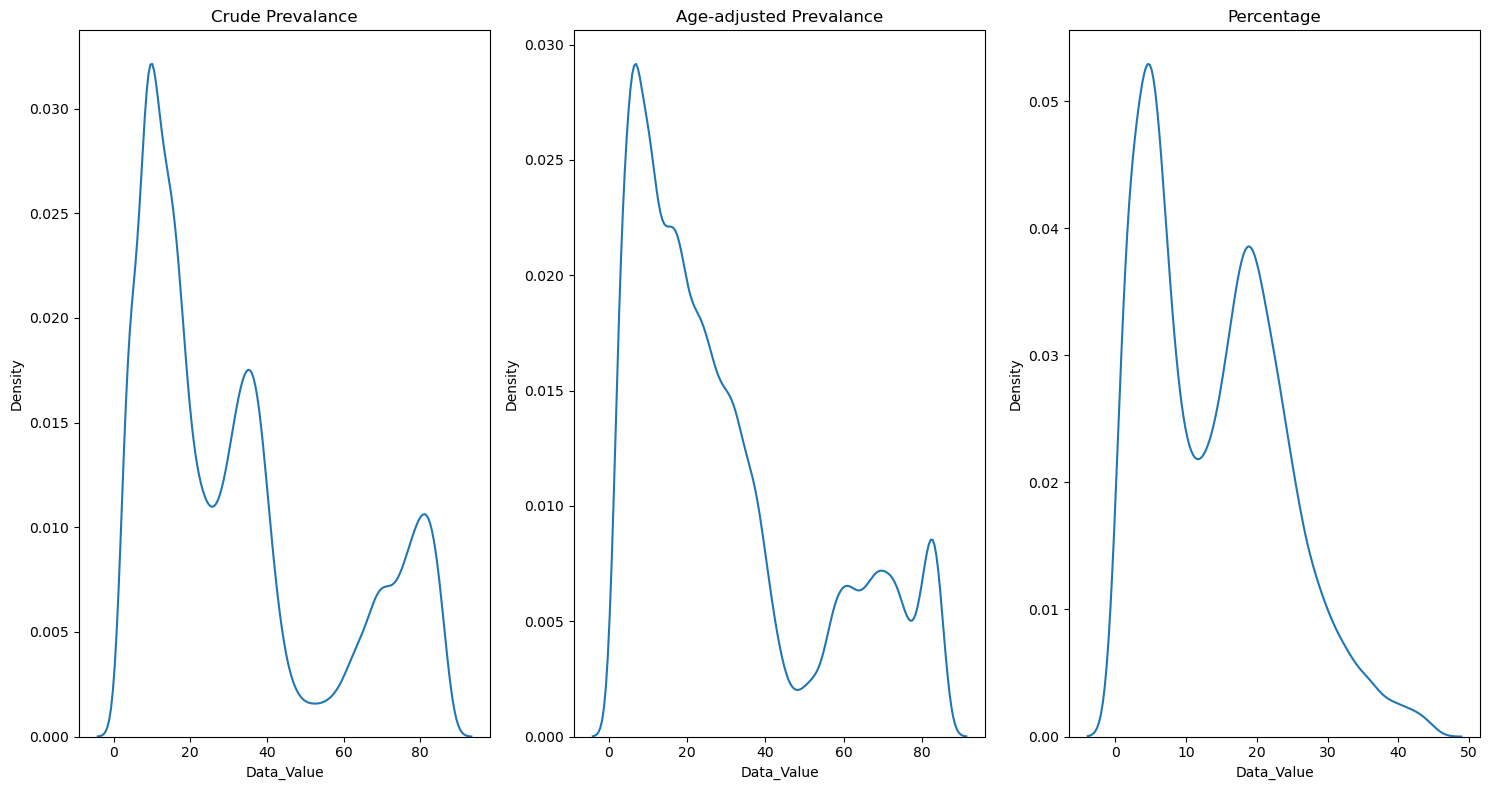

In [25]:
fig, ax = plt.subplots(ncols=3,figsize=(15,8))

sns.kdeplot(df_norm['Data_Value'].loc[df_norm['Data_Value_Type']=='crude prevalence'],ax=ax[0])
ax[0].set_title('Crude Prevalance')
sns.kdeplot(df_norm['Data_Value'].loc[df_norm['Data_Value_Type']=='age-adjusted prevalence'],ax=ax[1])
ax[1].set_title('Age-adjusted Prevalance')
sns.kdeplot(df_norm['Data_Value'].loc[df_norm['Data_Value_Type']=='percentage'],ax=ax[2])
ax[2].set_title('Percentage')
plt.tight_layout();

In [26]:
# Initialize RobustScaler
scaler = RobustScaler()

# Create an empty column for scaled values in the original DataFrame
df_norm.loc[:, 'Scaled_Value'] = pd.NA

# Process each data type separately
for data_type in df_norm['Data_Value_Type'].unique():
    # Filter the df to only include rows of the current data type
    subset = df_norm[df_norm['Data_Value_Type'] == data_type]
    
    # Reshape is used because scaler expects a 2D array
    scaled_values = scaler.fit_transform(subset['Data_Value'].values.reshape(-1, 1))

    # Assign the scaled values back to the appropriate rows in the main DataFrame
    df_norm.loc[subset.index, 'Scaled_Value'] = scaled_values.flatten()

# Ensure the scaled value is a float
df_norm['Scaled_Value'] = df_norm['Scaled_Value'].astype('float')


df_norm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 693472 entries, 0 to 808693
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            693472 non-null  category
 1   LocationName         693472 non-null  object  
 2   Category             693472 non-null  object  
 3   Data_Value_Type      693472 non-null  object  
 4   Data_Value           693472 non-null  float64 
 5   TotalPopulation      693472 non-null  int64   
 6   Short_Question_Text  693472 non-null  object  
 7   LocationID           693472 non-null  object  
 8   Geolocation          693472 non-null  object  
 9   Scaled_Value         693472 non-null  float64 
dtypes: category(1), float64(2), int64(1), object(6)
memory usage: 69.7+ MB


### Defining Health Disparity Index

Now that our dataframe is aligned with our project goals, we can define our target variable `Health_Disparity_Index`. 

To start, we will create a general index taking the sum of all scaled values for each location and create a feature in the full dataset to represent this disparity index. 

In [27]:
# Aggregate Scaled_Value per Geoplocation
sum_idx = df_norm.groupby('Geolocation')['Scaled_Value'].sum().reset_index()
sum_idx.rename({'Scaled_Value': 'Sum_Idx'},axis=1,inplace=True)

# Copy dataframe
df_sum_idx = df_norm.copy()

# Create new column
df_sum_idx = df_sum_idx.merge(sum_idx,on='Geolocation')
df_sum_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693472 entries, 0 to 693471
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            693472 non-null  category
 1   LocationName         693472 non-null  object  
 2   Category             693472 non-null  object  
 3   Data_Value_Type      693472 non-null  object  
 4   Data_Value           693472 non-null  float64 
 5   TotalPopulation      693472 non-null  int64   
 6   Short_Question_Text  693472 non-null  object  
 7   LocationID           693472 non-null  object  
 8   Geolocation          693472 non-null  object  
 9   Scaled_Value         693472 non-null  float64 
 10  Sum_Idx              693472 non-null  float64 
dtypes: category(1), float64(3), int64(1), object(6)
memory usage: 53.6+ MB


Comparing random samples of `Sum_Idx` vs `Data_Value` shows us that there is a lot more uniformity in the `Scaled_Value` before aggregation of all of the data value types. This makes sense since our aggregated `Sum_Idx` is combining all values per geolocation, creating and therefore creates less variability when visualizing by location.

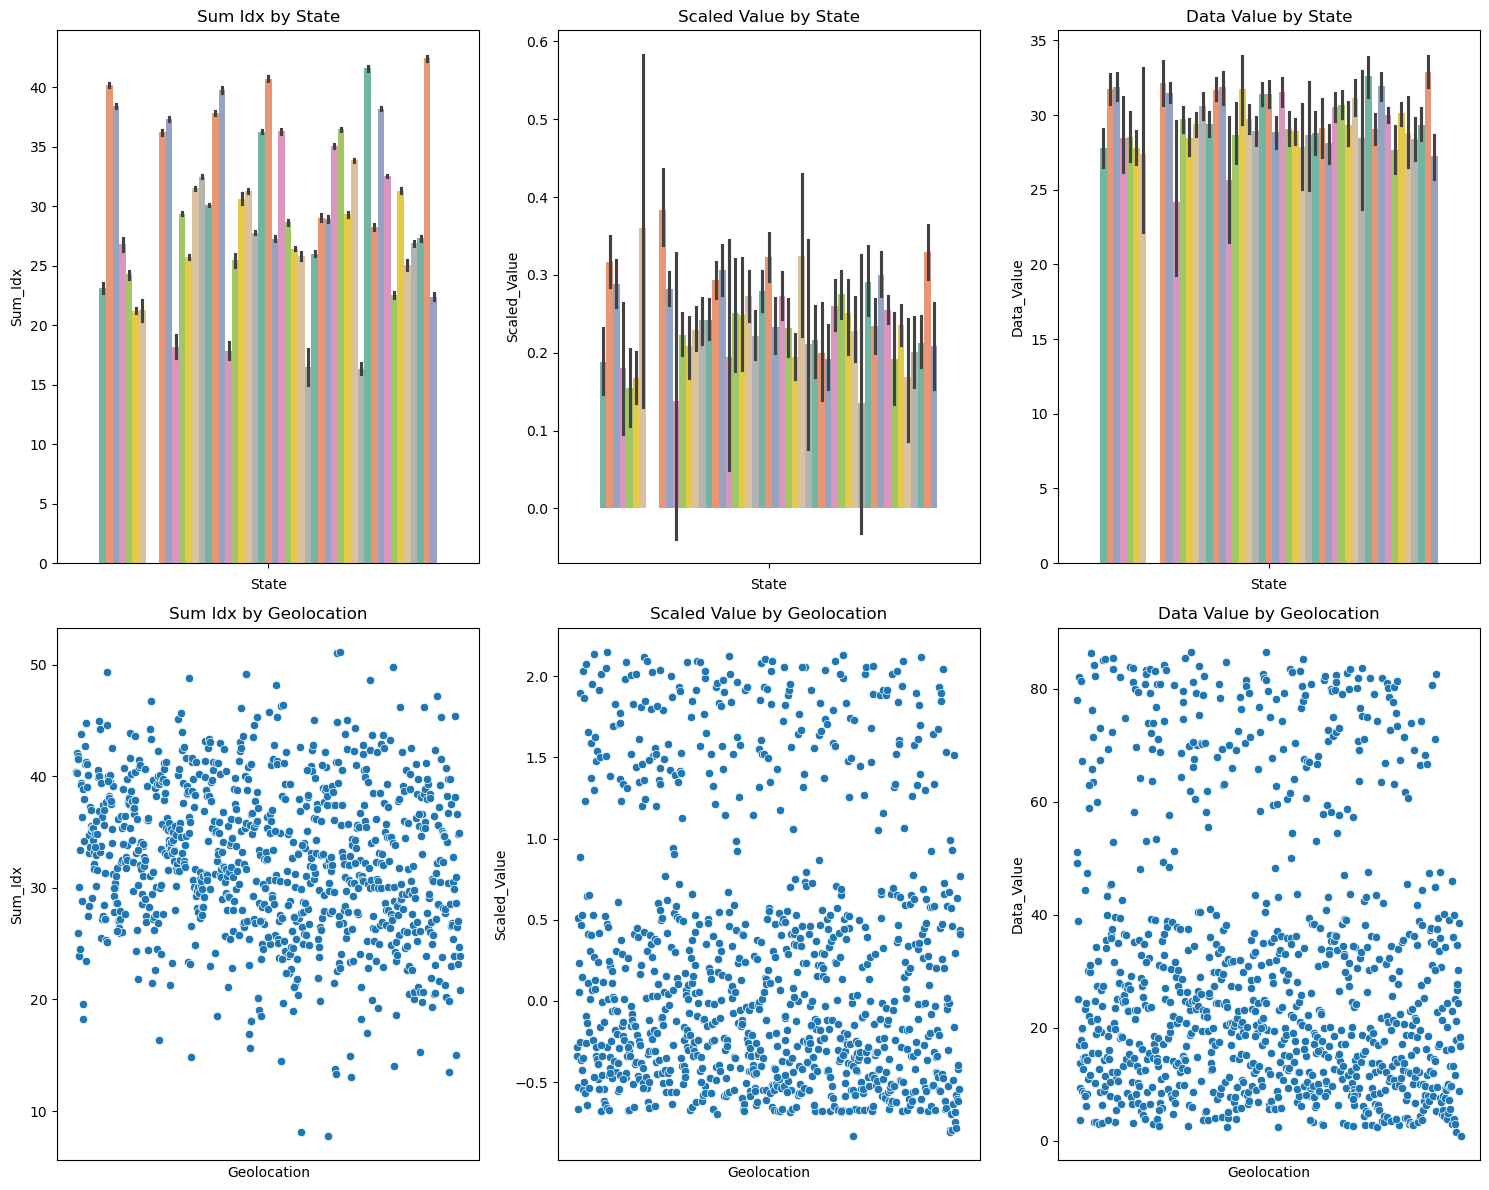

In [28]:
# Helper plotting function

def idx_plot(data,y1,y2,y3,y1_name,y2_name,y3_name):
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 12))

    # Visualize by State
    # Plot by y1
    sns.barplot(data=data, hue='StateAbbr', y=y1.sample(n=100000), 
                palette='Set2', ax=ax[0,0],legend=False)
    ax[0,0].set_title(f'{y1_name} by State')
    ax[0,0].set_xlabel('State')
    
    # Plot by y2
    sns.barplot(data=data, hue='StateAbbr', y=y2.sample(n=100000), 
                palette='Set2', ax=ax[0,1],legend=False)
    ax[0,1].set_title(f'{y2_name} by State')
    ax[0,1].set_xlabel('State') 

    # Plot by y3
    sns.barplot(data=data, hue='StateAbbr', y=y3.sample(n=100000), 
                palette='Set2', ax=ax[0,2],legend=False)
    ax[0,2].set_title(f'{y3_name} by State')
    ax[0,2].set_xlabel('State') 
    
    # Visualize by Geolocation
    # Plot by y1
    sns.scatterplot(data=data.sample(n=1000), x='Geolocation', y=y1, ax=ax[1, 0])
    ax[1, 0].set_title(f'{y1_name} by Geolocation')
    ax[1, 0].set_xlabel('Geolocation')

    ax[1, 0].set_xticks([])
    
    # Plot by y2
    sns.scatterplot(data=data.sample(n=1000), x='Geolocation', y=y2, ax=ax[1, 1])
    ax[1, 1].set_title(f'{y2_name} by Geolocation')
    ax[1, 1].set_xlabel('Geolocation')

    ax[1, 1].set_xticks([])

    # Plot by y3
    sns.scatterplot(data=data.sample(n=1000), x='Geolocation', y=y3, ax=ax[1, 2])
    ax[1, 2].set_title(f'{y3_name} by Geolocation')
    ax[1, 2].set_xlabel('Geolocation')

    ax[1, 2].set_xticks([])

    plt.tight_layout() 
    plt.show();

idx_plot(df_sum_idx,df_sum_idx['Sum_Idx'],df_sum_idx['Scaled_Value'],df_sum_idx['Data_Value'],'Sum Idx','Scaled Value','Data Value')

Let's see what our distribution looks like with an 'Avg_Idx' vs using raw sum of scaled values. 

In [29]:
# Aggregate Scaled_Value per Geoplocation
avg_idx = df_norm.groupby('Geolocation')['Scaled_Value'].mean().reset_index()
avg_idx.rename({'Scaled_Value': 'Avg_Idx'},axis=1,inplace=True)

# Copy dataframe
df_avg_idx = df_norm.copy()

# Create new column
df_avg_idx = df_avg_idx.merge(avg_idx,on='Geolocation')
df_avg_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693472 entries, 0 to 693471
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            693472 non-null  category
 1   LocationName         693472 non-null  object  
 2   Category             693472 non-null  object  
 3   Data_Value_Type      693472 non-null  object  
 4   Data_Value           693472 non-null  float64 
 5   TotalPopulation      693472 non-null  int64   
 6   Short_Question_Text  693472 non-null  object  
 7   LocationID           693472 non-null  object  
 8   Geolocation          693472 non-null  object  
 9   Scaled_Value         693472 non-null  float64 
 10  Avg_Idx              693472 non-null  float64 
dtypes: category(1), float64(3), int64(1), object(6)
memory usage: 53.6+ MB


When we create an `Avg_Idx` we now see our geolocation distribution but on a different scale and with more goeographical distinction. 

> This would make sense if for example, this segregation is representing rural vs urban areas.

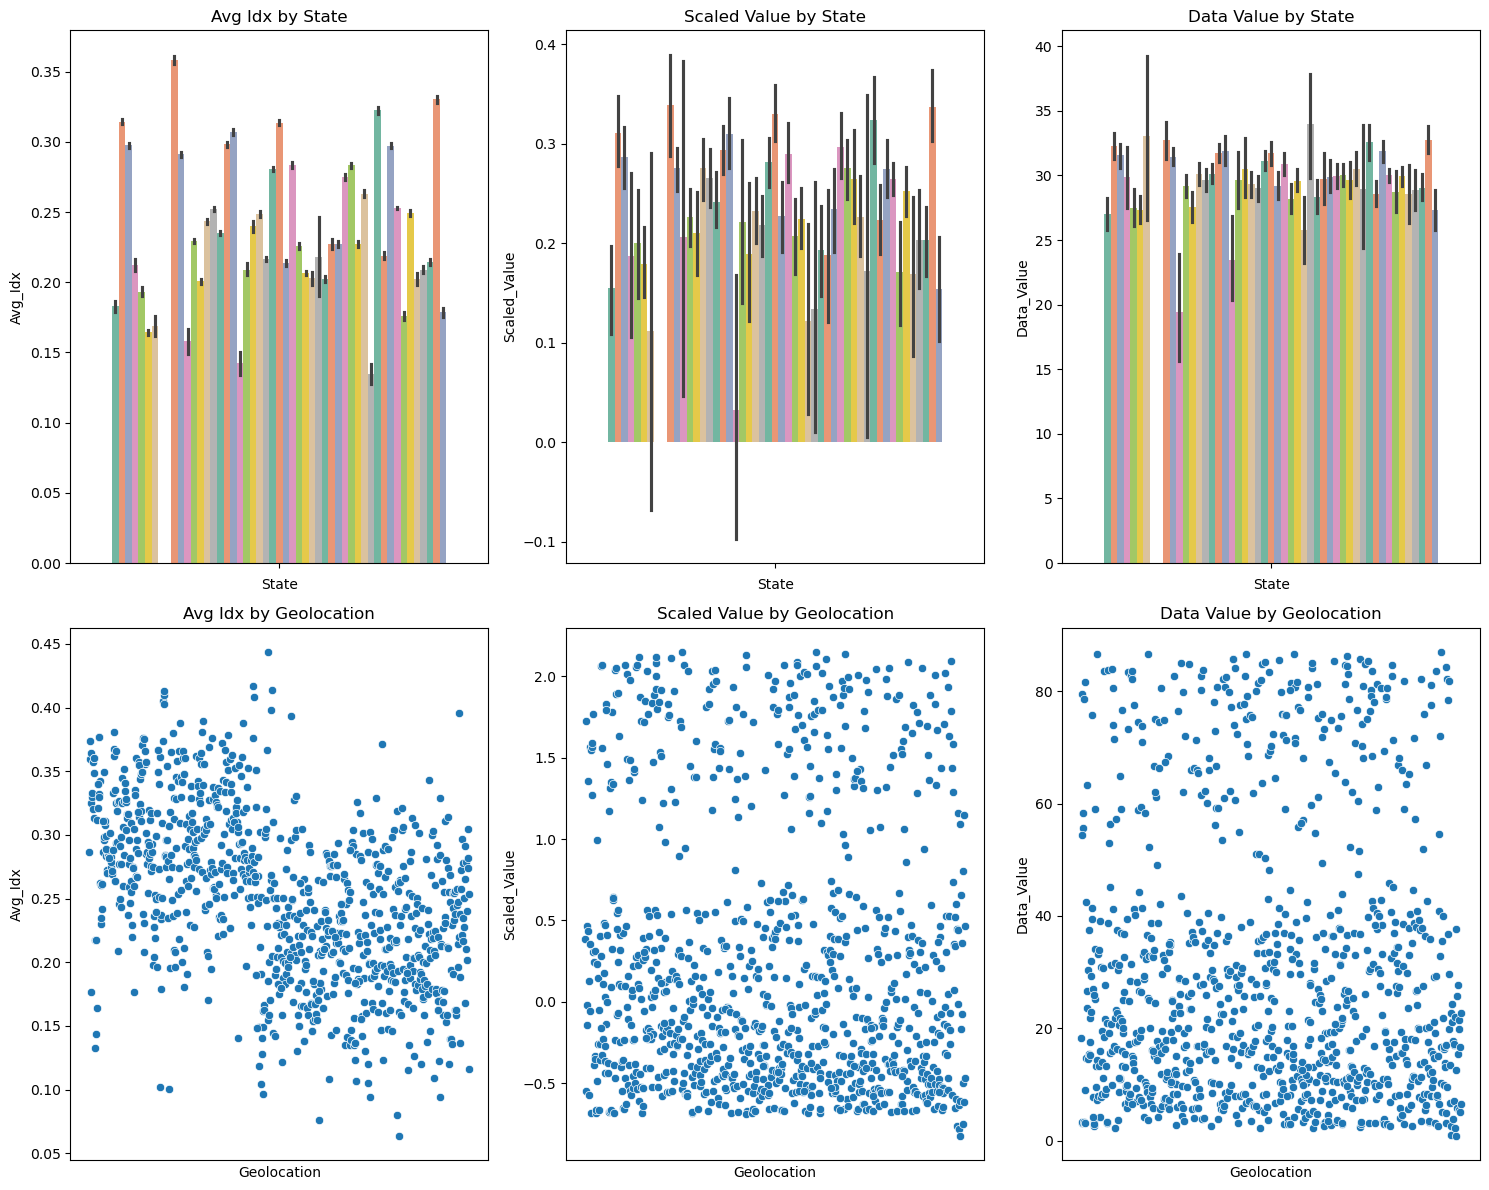

In [30]:
idx_plot(df_avg_idx,df_avg_idx['Avg_Idx'],df_avg_idx['Scaled_Value'],df_avg_idx['Data_Value'],'Avg Idx','Scaled Value','Data Value')

Lastly we will add a population weight to each scaled value, this will adjust our results to consider the density of a region when calculating the HDI.

In [31]:
# Aggregate Scaled_Value per Geoplocation
pw_idx = df_norm.groupby('Geolocation')['TotalPopulation'].sum().reset_index()
pw_idx.rename({'TotalPopulation': 'GeoPop'},axis=1,inplace=True)

# Copy dataframe
df_pw_idx = df_norm.copy()

# Create new column
df_pw_idx = df_pw_idx.merge(pw_idx,on='Geolocation')

# Calculate weights
df_pw_idx['PopWeight'] = df_pw_idx['TotalPopulation']/df_pw_idx['GeoPop']

# Calculate weighted average of health measures
weighted_avg = df_pw_idx.groupby('Geolocation').apply(lambda x: (x['Scaled_Value']*x['PopWeight']).sum()).reset_index(name='Weighted_Idx')

df_pw_idx = df_pw_idx.merge(weighted_avg,on='Geolocation')

df_pw_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693472 entries, 0 to 693471
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            693472 non-null  category
 1   LocationName         693472 non-null  object  
 2   Category             693472 non-null  object  
 3   Data_Value_Type      693472 non-null  object  
 4   Data_Value           693472 non-null  float64 
 5   TotalPopulation      693472 non-null  int64   
 6   Short_Question_Text  693472 non-null  object  
 7   LocationID           693472 non-null  object  
 8   Geolocation          693472 non-null  object  
 9   Scaled_Value         693472 non-null  float64 
 10  GeoPop               693472 non-null  int64   
 11  PopWeight            693472 non-null  float64 
 12  Weighted_Idx         693472 non-null  float64 
dtypes: category(1), float64(4), int64(2), object(6)
memory usage: 64.2+ MB


Looks like our weighted average provides more of a spread than the `Avg_Idx, and the same relationship as the `Avg_Idx` which means population definitely has an impact on the HDI and geolocation does as well.

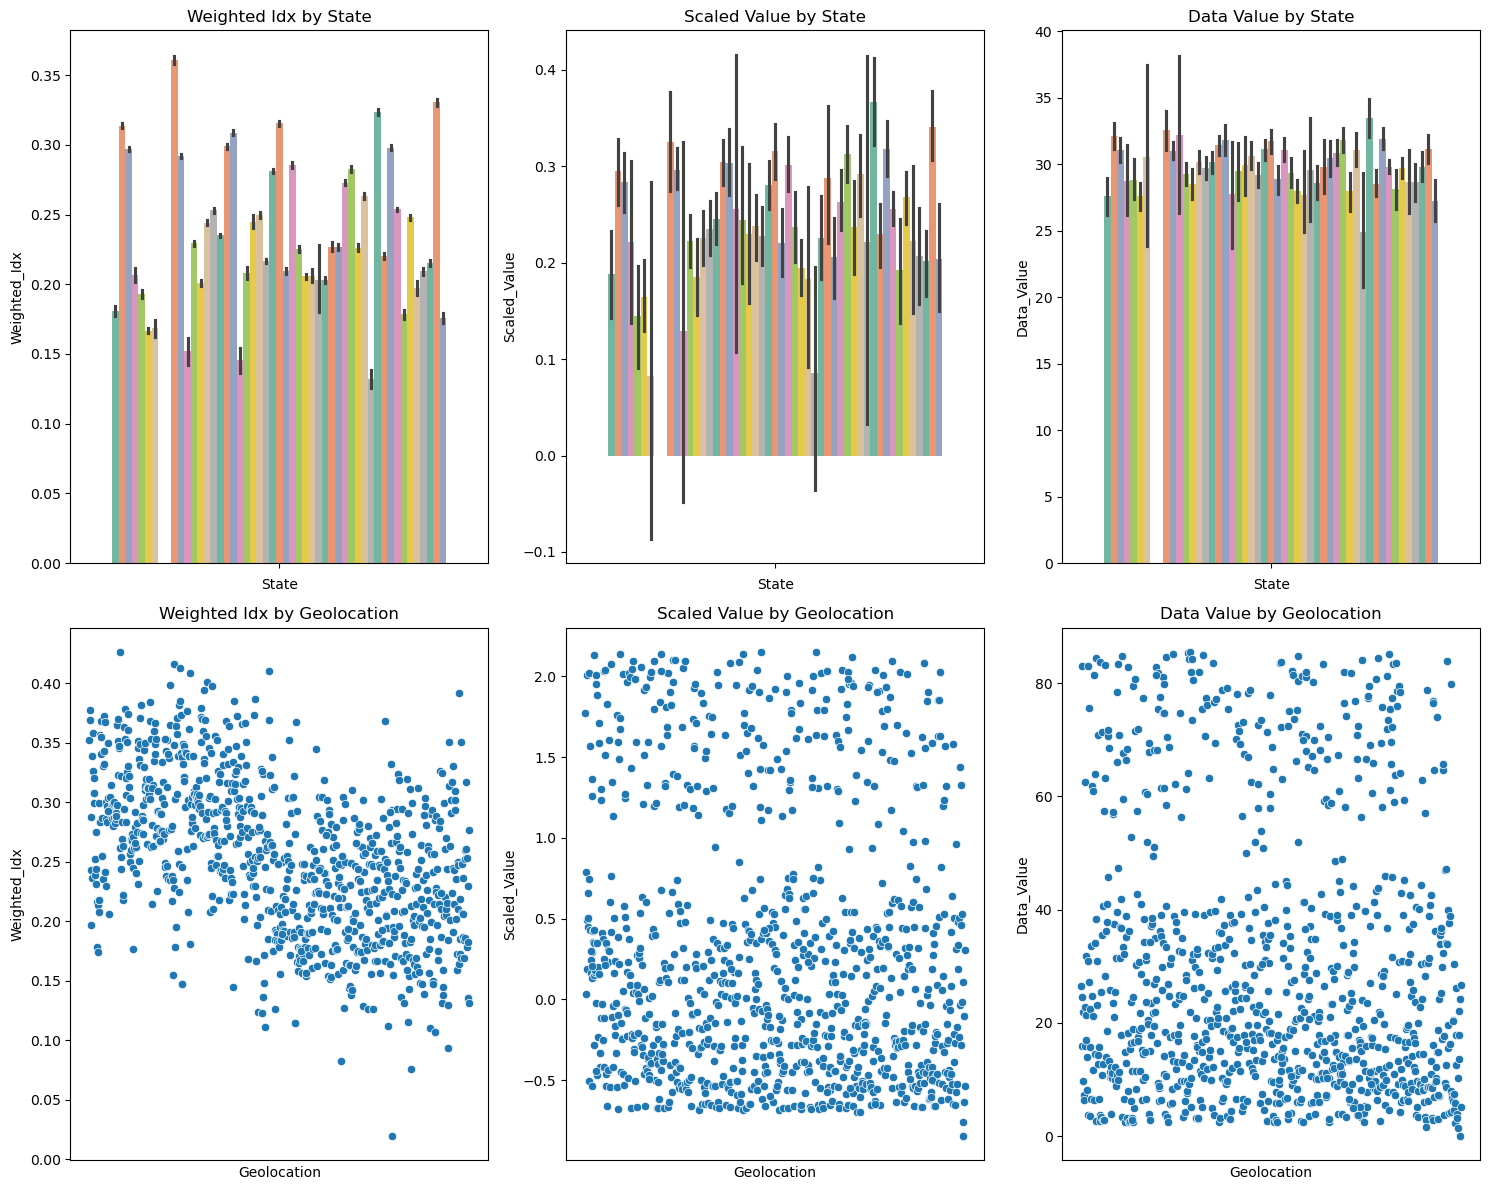

In [32]:
idx_plot(df_pw_idx,df_pw_idx['Weighted_Idx'],df_pw_idx['Scaled_Value'],df_pw_idx['Data_Value'],'Weighted Idx','Scaled Value','Data Value')

### Geolocation to HDI Visualization

Before we finalize our decision to use the population weighted HDI, let's visualize the index in comparison to population using the `Geolocation`. To do so, we first have to convert the feature to wkt (well-known text) format for use with the geopandas library.

In [33]:
df_pw_idx.loc[:,'Geolocation']= df_pw_idx['Geolocation'].apply(lambda x: x.upper())
df_pw_idx.loc[:,'Geolocation'] = df_pw_idx['Geolocation'].apply(wkt.loads)
df_pw_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693472 entries, 0 to 693471
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            693472 non-null  category
 1   LocationName         693472 non-null  object  
 2   Category             693472 non-null  object  
 3   Data_Value_Type      693472 non-null  object  
 4   Data_Value           693472 non-null  float64 
 5   TotalPopulation      693472 non-null  int64   
 6   Short_Question_Text  693472 non-null  object  
 7   LocationID           693472 non-null  object  
 8   Geolocation          693472 non-null  object  
 9   Scaled_Value         693472 non-null  float64 
 10  GeoPop               693472 non-null  int64   
 11  PopWeight            693472 non-null  float64 
 12  Weighted_Idx         693472 non-null  float64 
dtypes: category(1), float64(4), int64(2), object(6)
memory usage: 64.2+ MB


Now we can create a GeoDataFrame with `Geolocation` as the geometrical feature.

In [34]:
gdf_pw = gpd.GeoDataFrame(df_pw_idx,geometry='Geolocation')

Looking at population and the HDI across all of the geolocations we can see that the higher the population, the lower the HDI. In particular we can see that in part of the west coast, Florida, and part of the east coast demonstrate this inverse relationship.

> This inverse relationship may make sense when you consider factors such as but not limited to; greater access to care, diversity of services, and public health funding in areas with more population density.

This further confirms our decision to use population as a weight for our HDI definition.

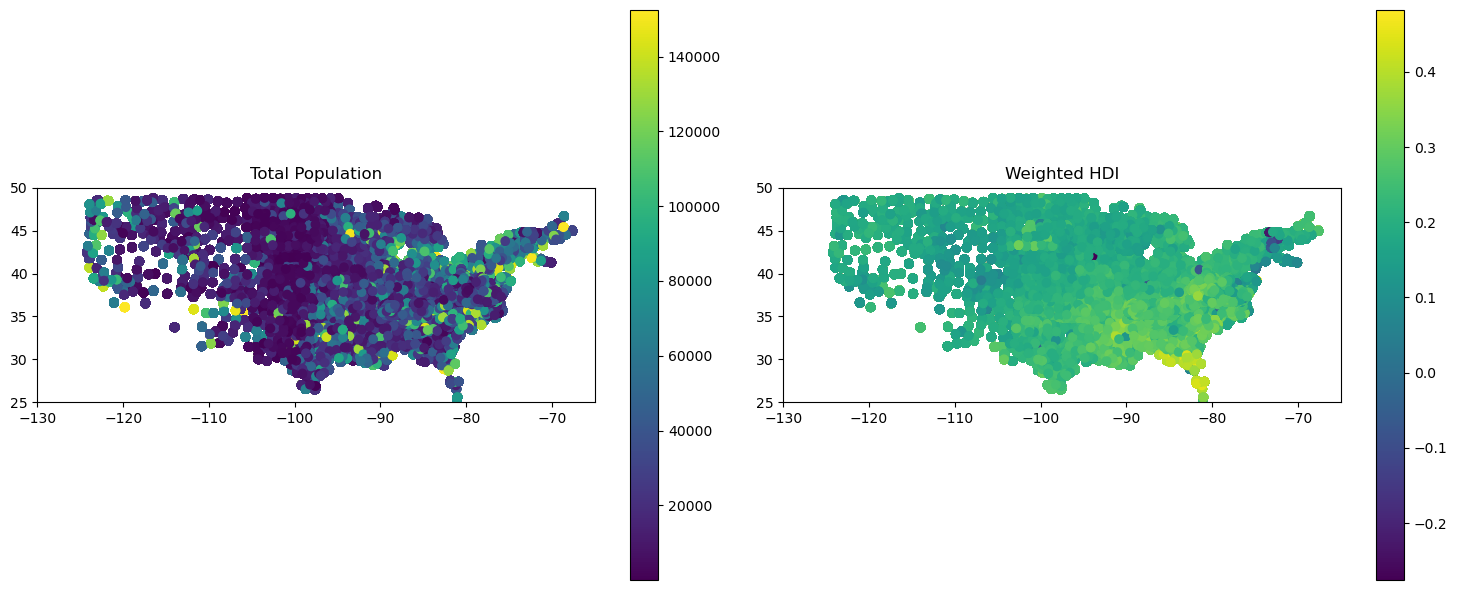

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting 'TotalPopulation'
gdf_pw.plot(column='TotalPopulation', legend=True, ax=ax[0])
ax[0].set_title('Total Population')
ax[0].set_xlim(-130, -65)
ax[0].set_ylim(25, 50)

# Plotting 'Sum_Idx'
gdf_pw.plot(column='Weighted_Idx', legend=True, ax=ax[1])
ax[1].set_title('Weighted HDI')
ax[1].set_xlim(-130, -65)
ax[1].set_ylim(25, 50)

plt.tight_layout();

## Data Preparation

Since our dataset is so large we will train our model on a smaller training set to save computational power and time. We are also going to drop the columns we used to create our `Weighted_Idx`. 

> In future itterations we would want to consider using `Geolocation` to create location features and explore spatial relationships. However, to keep computational cost relatively low, we will note this as a Phase 2 addition.

A subset is created to make sure that we are able to understand model performance while maintaining computational efficiency. Once we have found the best fitting model, we will run it on our extra hold out data we didn't train on, further validating our results.

In [36]:
# Shuffle data for random distribution
df_samp = df_pw_idx.sample(n=150000,random_state=42)

# Capture unused indexes
unused_indexes = df_pw_idx.index.difference(df_samp.index)

# Create holdout data for extra validation
df_holdout = df_pw_idx.loc[unused_indexes]
X_holdout = df_holdout.drop(columns=['Weighted_Idx','GeoPop','PopWeight','Scaled_Value','Geolocation'])
y_holdout = df_holdout['Weighted_Idx']

# Define X, y, and split data
X = df_samp.drop(columns=['Weighted_Idx','GeoPop','PopWeight','Scaled_Value','Geolocation'])
y = df_samp['Weighted_Idx']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

print(X_train.shape)
X_train.info()

(120000, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 120000 entries, 27042 to 243103
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   StateAbbr            120000 non-null  category
 1   LocationName         120000 non-null  object  
 2   Category             120000 non-null  object  
 3   Data_Value_Type      120000 non-null  object  
 4   Data_Value           120000 non-null  float64 
 5   TotalPopulation      120000 non-null  int64   
 6   Short_Question_Text  120000 non-null  object  
 7   LocationID           120000 non-null  object  
dtypes: category(1), float64(1), int64(1), object(5)
memory usage: 7.4+ MB


In [37]:
# Save full X for deployment
X.to_csv('data/X_raw.csv',index=False)

# Save data types
data_types = X.dtypes.astype(str).to_dict()
pd.Series(data_types).to_json('data/data_types.json')

### Base Model and Metrics

`StandardScaler` is used on all our numerical data to make sure we are comparing our features on the same scale. And `OneHotEncoder` is used on the rest of the object or categorical categories. 

Our base model will be a standard `LinearRegression`.

In [38]:
# Define the features by names
categorical_features = ['StateAbbr', 'LocationName', 'Category', 'Data_Value_Type', 'Short_Question_Text', 'LocationID']
numerical_features = ['Data_Value', 'TotalPopulation']

# Create transformers for categorical and numerical columns
transformers = [
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
]

# Build the ColumnTransformer
column_transformer = ColumnTransformer(transformers)

# Build the initial pipeline
init_pipe = Pipeline([
    ('preprocessor', column_transformer),
    ('model', LinearRegression())])

In [39]:
init_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Data_Value',
                                                   'TotalPopulation']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['StateAbbr', 'LocationName',
                                                   'Category',
                                                   'Data_Value_Type',
                                                   'Short_Question_Text',
                                                   'LocationID'])])),
                ('model', LinearRegression())])

Our error metrics don't look too bad, but the $R^2$ is way off! Let's try other models to see how our predictions can improve.

We will keep these metrics in mind as we test other models.

In [40]:
# Baseline Metrics
print('Train RSME:', root_mean_squared_error(y_train,init_pipe.predict(X_train)))
print('Test RSME:', root_mean_squared_error(y_test,init_pipe.predict(X_test)))
print('Train R-Squared:', r2_score(y_train,init_pipe.predict(X_train)))
print('Test R-Squared:', r2_score(y_test,init_pipe.predict(X_test)))
print('Train MAE:', mean_absolute_error(y_train,init_pipe.predict(X_train)))
print('Test MAE:', mean_absolute_error(y_test,init_pipe.predict(X_test)))

Train RSME: 0.03585990325697446
Test RSME: 168035577.28961942
Train R-Squared: 0.6965613324011881
Test R-Squared: -6.707181351404675e+18
Train MAE: 0.031630665651448904
Test MAE: 1909482.0151426143


Even after dropping a significant amount of features, we are left with fairly high dimentionality. This is something we will want to consider as we test and refine our models.

In [41]:
X_train_trans = init_pipe['preprocessor'].transform(X_train)
df_trans = pd.DataFrame(X_train_trans,columns=init_pipe['preprocessor'].get_feature_names_out())
print(df_trans.shape)
df_trans

(120000, 4508)


,num__Data_Value,num__TotalPopulation,cat__StateAbbr_ak,cat__StateAbbr_al,cat__StateAbbr_ar,cat__StateAbbr_az,cat__StateAbbr_ca,cat__StateAbbr_co,cat__StateAbbr_ct,cat__StateAbbr_fl,...,cat__LocationID_8109,cat__LocationID_8111,cat__LocationID_8113,cat__LocationID_8115,cat__LocationID_8117,cat__LocationID_8119,cat__LocationID_8121,cat__LocationID_8125,cat__LocationID_9013,cat__LocationID_9015
0,1.373656,-0.416407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.568548,0.440598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.246002,1.997718,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.743992,0.149095,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.922424,1.449721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,-0.111800,-0.228281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119996,1.587628,-0.423428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119997,-1.082902,-0.757399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119998,-0.963572,-0.380616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Linear Regression

Now to add some regularization with `Lasso` and `Ridge`.

> Going forward we will tune our hyperparameters and perform cross validation though the custom `MetricsCV` class which offers the option of using `RandomizedSearchCV` or `gp_optimize` and the objective function for hyper parameter tuning. For those cases where hyperparameter tuning isn't necessary, there is an option to only cross validate.

In [42]:
# Helper function to create new pipeline for each model

def new_pipe(estimator):
    return Pipeline(steps=[
        ('preprocessor', column_transformer),  
        ('model', estimator)
    ])

### Lasso

Let's see if we can improve our metrics with a linear model as well as utilize the feature selection capabilities.

In [43]:
# Replace in pipeline
lasso_pipe = new_pipe(Lasso(max_iter=10000, random_state=seed_value))
lasso_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Data_Value',
                                                   'TotalPopulation']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['StateAbbr', 'LocationName',
                                                   'Category',
                                                   'Data_Value_Type',
                                                   'Short_Question_Text',
                                                   'LocationID'])])),
                ('model', Lasso(max_iter=10000, random_state=42))])

In [44]:
mcv_lasso = MetricsCV(lasso_pipe,'Lasso',X_train,y_train)

params_lasso = {'model__alpha': [.0001,.001,.01,100,1000],
                'model__selection': ['cyclic','random']
}

mcv_lasso.run_rcv(params=params_lasso,scoring="neg_root_mean_squared_error",
                                             verbose=3,n_iter=4,kfolds=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END model__alpha=0.001, model__selection=cyclic;, score=(train=-0.059, test=-0.059) total time=   4.7s
[CV 2/5] END model__alpha=0.001, model__selection=cyclic;, score=(train=-0.059, test=-0.059) total time=   4.4s
[CV 3/5] END model__alpha=0.001, model__selection=cyclic;, score=(train=-0.059, test=-0.059) total time=   4.5s
[CV 4/5] END model__alpha=0.001, model__selection=cyclic;, score=(train=-0.059, test=-0.059) total time=   4.6s
[CV 5/5] END model__alpha=0.001, model__selection=cyclic;, score=(train=-0.059, test=-0.059) total time=   4.7s
[CV 1/5] END model__alpha=0.01, model__selection=random;, score=(train=-0.065, test=-0.065) total time=   3.8s
[CV 2/5] END model__alpha=0.01, model__selection=random;, score=(train=-0.065, test=-0.065) total time=   3.7s
[CV 3/5] END model__alpha=0.01, model__selection=random;, score=(train=-0.065, test=-0.065) total time=   3.9s
[CV 4/5] END model__alpha=0.01, model__selectio

{'model__selection': 'cyclic', 'model__alpha': 0.001}

In [45]:
# Get validation scores and best estimator
val_scores, lasso_best = mcv_lasso.rcv_metrics()

In [46]:
# View best params
lasso_best['model'].get_params

<bound method BaseEstimator.get_params of Lasso(alpha=0.001, max_iter=10000, random_state=42)>

It looks like the metrics are a lot more balanced and the error metrics look pretty good! However, the $R^2$ could stand to improve.

In [47]:
test_scores = mcv_lasso.test_metrics(X_test,y_test)
display(val_scores)
test_scores

,Model Name,Val Train RMSE,Val Test RMSE
0,Lasso,0.06356,0.06356


,Model Name,Train RMSE,Test RMSE,Train R2,Test R2,Train MAE,Test MAE
0,Lasso,0.05893,0.05877,0.18064,0.17953,0.04830,0.04841


### Ridge

Now we can assess the Ridge model in comparison to Lasso to see which type of regularization is best for our problem.

In [48]:
# Replace in pipeline
ridge_pipe = new_pipe(Ridge(random_state=seed_value))
ridge_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Data_Value',
                                                   'TotalPopulation']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['StateAbbr', 'LocationName',
                                                   'Category',
                                                   'Data_Value_Type',
                                                   'Short_Question_Text',
                                                   'LocationID'])])),
                ('model', Ridge(random_state=42))])

In [49]:
mcv_ridge = MetricsCV(ridge_pipe,'Ridge',X_train,y_train)

params_ridge = {'model__alpha': [.00001,.0001,.001,.01,100,1000,10000],
                'model__solver': ['auto','cholesky','lsqr','sag'],
                'model__tol': [.0001,.001,.01]
}

mcv_ridge.run_rcv(params=params_ridge,scoring="neg_root_mean_squared_error",
                                             verbose=3,n_iter=5,kfolds=5)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END model__alpha=1e-05, model__solver=lsqr, model__tol=0.001;, score=(train=-0.036, test=-0.037) total time=   6.1s
[CV 2/5] END model__alpha=1e-05, model__solver=lsqr, model__tol=0.001;, score=(train=-0.036, test=-0.037) total time=   7.7s
[CV 3/5] END model__alpha=1e-05, model__solver=lsqr, model__tol=0.001;, score=(train=-0.036, test=-0.037) total time=   7.8s
[CV 4/5] END model__alpha=1e-05, model__solver=lsqr, model__tol=0.001;, score=(train=-0.036, test=-0.037) total time=   8.4s
[CV 5/5] END model__alpha=1e-05, model__solver=lsqr, model__tol=0.001;, score=(train=-0.036, test=-0.037) total time=   7.6s
[CV 1/5] END model__alpha=10000, model__solver=auto, model__tol=0.01;, score=(train=-0.059, test=-0.059) total time=  14.6s
[CV 2/5] END model__alpha=10000, model__solver=auto, model__tol=0.01;, score=(train=-0.059, test=-0.059) total time=  18.5s
[CV 3/5] END model__alpha=10000, model__solver=auto, model__tol=0.0

{'model__tol': 0.0001, 'model__solver': 'auto', 'model__alpha': 0.001}

In [50]:
# Get validation scores and best estimator
val_scores, ridge_best = mcv_ridge.rcv_metrics(val_df=val_scores)

In [51]:
# View best params
ridge_best['model'].get_params

<bound method BaseEstimator.get_params of Ridge(alpha=0.001, random_state=42)>

The metrics look better, there is some light overfitting but not too concerning.

In [52]:
test_scores = mcv_ridge.test_metrics(X_test,y_test,test_df=test_scores)
display(val_scores)
test_scores

,Model Name,Val Train RMSE,Val Test RMSE
1,Ridge,0.04136,0.04210
0,Lasso,0.06356,0.06356


,Model Name,Train RMSE,Test RMSE,Train R2,Test R2,Train MAE,Test MAE
1,Ridge,0.03583,0.03672,0.69706,0.67978,0.03162,0.03247
0,Lasso,0.05893,0.05877,0.18064,0.17953,0.04830,0.04841


## RandomForest

Let's see if metrics can improve further with a `RandomForestRegressor`. It's robust algorithm may boost the $R^2$ the way we need.

> To concerve time and computational resources, we are setting `n_jobs` to -1 for parallel processing,`warm_start` to True, and `bootstrap~ to False to speed up the tuning of the trees.

In [53]:
# Replace in pipeline
random_pipe = new_pipe(RandomForestRegressor(random_state=seed_value,
                                             n_jobs=-1, 
                                             warm_start=True, 
                                             bootstrap=False))
random_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Data_Value',
                                                   'TotalPopulation']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['StateAbbr', 'LocationName',
                                                   'Category',
                                                   'Data_Value_Type',
                                                   'Short_Question_Text',
                                                   'LocationID'])])),
                ('model',
                 RandomForestRegressor(bootstrap=False, n_jobs=-1,
                                       random_state=42, warm_start=True))])

In [54]:
mcv_random = MetricsCV(random_pipe,'Random',X_train,y_train)

params_random = {'model__n_estimators': [100, 300, 500, 800],
    'model__max_features': ['sqrt', 'log2'],
    'model__max_depth': [10, 20, 30, 50],
    'model__min_samples_split': [10, 15, 100],
    'model__min_samples_leaf': [1, 2, 5, 10]
}


mcv_random.run_rcv(params=params_random,scoring="neg_root_mean_squared_error",
                                             verbose=3,n_iter=5,kfolds=3)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END model__max_depth=30, model__max_features=log2, model__min_samples_leaf=10, model__min_samples_split=100, model__n_estimators=300;, score=(train=-0.061, test=-0.061) total time=  20.7s
[CV 2/3] END model__max_depth=30, model__max_features=log2, model__min_samples_leaf=10, model__min_samples_split=100, model__n_estimators=300;, score=(train=-0.061, test=-0.061) total time=  21.3s
[CV 3/3] END model__max_depth=30, model__max_features=log2, model__min_samples_leaf=10, model__min_samples_split=100, model__n_estimators=300;, score=(train=-0.061, test=-0.061) total time=  21.9s
[CV 1/3] END model__max_depth=20, model__max_features=log2, model__min_samples_leaf=5, model__min_samples_split=15, model__n_estimators=500;, score=(train=-0.062, test=-0.062) total time=  23.8s
[CV 2/3] END model__max_depth=20, model__max_features=log2, model__min_samples_leaf=5, model__min_samples_split=15, model__n_estimators=500;, score=(train

{'model__n_estimators': 800,
 'model__min_samples_split': 15,
 'model__min_samples_leaf': 2,
 'model__max_features': 'sqrt',
 'model__max_depth': 30}

In [55]:
# Get validation scores and best estimator
val_scores, random_best = mcv_random.rcv_metrics(val_df=val_scores)

In [56]:
# View best params
random_best['model'].get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=15,
                      n_estimators=800, n_jobs=-1, random_state=42,
                      warm_start=True)>

The Random Forest didn't do as well as hoped. The Ridge model is still the best holistically.

In [57]:
test_scores = mcv_random.test_metrics(X_test,y_test,test_df=test_scores)
display(val_scores)
test_scores

,Model Name,Val Train RMSE,Val Test RMSE
0,Ridge,0.04136,0.04210
2,Random,0.05784,0.05806
1,Lasso,0.06356,0.06356


,Model Name,Train RMSE,Test RMSE,Train R2,Test R2,Train MAE,Test MAE
0,Ridge,0.03583,0.03672,0.69706,0.67978,0.03162,0.03247
2,Random,0.05293,0.05316,0.33885,0.32879,0.04423,0.04458
1,Lasso,0.05893,0.05877,0.18064,0.17953,0.04830,0.04841


## VotingRegressor

Let's try a `VotingRegressor` to see if we can combine the top two models to get better scores.

In [58]:
# Create weighted averaging 

estimators = [
    ('ridge',ridge_best['model']),
    ('lasso',lasso_pipe['model'])]

voting_pipe = new_pipe(VotingRegressor(estimators=estimators))

voting_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Data_Value',
                                                   'TotalPopulation']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['StateAbbr', 'LocationName',
                                                   'Category',
                                                   'Data_Value_Type',
                                                   'Short_Question_Text',
                                                   'LocationID'])])),
                ('model',
                 VotingRegressor(estimators=[('ridge',
                                              Ridge(alpha=0.001,
                                                    random_state=42)),
                                             ('lasso',
                                              Lasso(max_iter=10000,
                                                    random_state=42))]))])

Let's test out a couple of different weight distributions and cross validate our results.

In [59]:
mcv_voting = MetricsCV(voting_pipe,'Voting',X_train,y_train)

params_voting = {"model__weights": [[0.70,0.30],[0.60,0.40],[0.80,0.20]]}

mcv_voting.run_rcv(params=params_voting,scoring="neg_root_mean_squared_error",
                                             verbose=3,n_iter=3,kfolds=5)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END model__weights=[0.7, 0.3];, score=(train=-0.039, test=-0.040) total time=  18.3s
[CV 2/5] END model__weights=[0.7, 0.3];, score=(train=-0.039, test=-0.040) total time=  18.8s
[CV 3/5] END model__weights=[0.7, 0.3];, score=(train=-0.039, test=-0.040) total time=  20.4s
[CV 4/5] END model__weights=[0.7, 0.3];, score=(train=-0.039, test=-0.040) total time=  20.6s
[CV 5/5] END model__weights=[0.7, 0.3];, score=(train=-0.039, test=-0.040) total time=  24.1s
[CV 1/5] END model__weights=[0.6, 0.4];, score=(train=-0.042, test=-0.042) total time=  24.6s
[CV 2/5] END model__weights=[0.6, 0.4];, score=(train=-0.042, test=-0.042) total time=  21.5s
[CV 3/5] END model__weights=[0.6, 0.4];, score=(train=-0.042, test=-0.043) total time=  24.5s
[CV 4/5] END model__weights=[0.6, 0.4];, score=(train=-0.042, test=-0.042) total time=  25.4s
[CV 5/5] END model__weights=[0.6, 0.4];, score=(train=-0.042, test=-0.043) total time=  24.9s


{'model__weights': [0.8, 0.2]}

In [60]:
# Get validation scores and best estimator
val_scores, voting_best = mcv_voting.rcv_metrics(val_df=val_scores)

In [61]:
# View best params
voting_best['model'].get_params

<bound method _BaseHeterogeneousEnsemble.get_params of VotingRegressor(estimators=[('ridge', Ridge(alpha=0.001, random_state=42)),
                            ('lasso', Lasso(max_iter=10000, random_state=42))],
                weights=[0.8, 0.2])>

Looks like our Ridge model is still the strongest. 

In [62]:
test_scores = mcv_voting.test_metrics(X_test,y_test,test_df=test_scores)
display(val_scores)
test_scores

,Model Name,Val Train RMSE,Val Test RMSE
3,Voting,0.03949,0.04018
0,Ridge,0.04136,0.04210
1,Random,0.05784,0.05806
2,Lasso,0.06356,0.06356


,Model Name,Train RMSE,Test RMSE,Train R2,Test R2,Train MAE,Test MAE
0,Ridge,0.03583,0.03672,0.69706,0.67978,0.03162,0.03247
3,Voting,0.03744,0.03810,0.66916,0.65510,0.03280,0.03353
1,Random,0.05293,0.05316,0.33885,0.32879,0.04423,0.04458
2,Lasso,0.05893,0.05877,0.18064,0.17953,0.04830,0.04841


## StackingRegressor

Lastly, we will try another ensemble model with the `StackingRegressor`.

In [63]:
estimators = [
    ('ridge',ridge_best['model']),
    ('lasso',lasso_best['model'])]


stacking_pipe = new_pipe(StackingRegressor(estimators=estimators))

stacking_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Data_Value',
                                                   'TotalPopulation']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['StateAbbr', 'LocationName',
                                                   'Category',
                                                   'Data_Value_Type',
                                                   'Short_Question_Text',
                                                   'LocationID'])])),
                ('model',
                 StackingRegressor(estimators=[('ridge',
                                                Ridge(alpha=0.001,
                                                      random_state=42)),
                                               ('lasso',
                                                Lasso(alpha=0.001,
                                                      max_iter=10000,
                                                      random_state=42))]))])

In [64]:
mcv_stacking = MetricsCV(stacking_pipe,'Stacking',X_train,y_train)

# Perform cross validation and get metrics
val_scores = mcv_stacking.cross_val(scoring='neg_root_mean_squared_error',val_df=val_scores,verbose=3,kfolds=3)
test_scores = mcv_stacking.test_metrics(X_test,y_test,test_df=test_scores,test_pipe=stacking_pipe)

[CV] END ................., score=(train=-0.036, test=-0.037) total time= 2.0min
[CV] END ................., score=(train=-0.036, test=-0.037) total time= 1.5min
[CV] END ................., score=(train=-0.036, test=-0.037) total time= 1.8min


While not a huge improvement all of the metrics improved slightly with the `StackingRegressor`.

In [65]:
display(val_scores)
test_scores

,Model Name,Val Train RMSE,Val Test RMSE
0,Voting,0.03949,0.04018
1,Ridge,0.04136,0.04210
2,Random,0.05784,0.05806
3,Lasso,0.06356,0.06356
4,Stacking,0.03564,0.03694


,Model Name,Train RMSE,Test RMSE,Train R2,Test R2,Train MAE,Test MAE
4,Stacking,0.03584,0.03670,0.69685,0.67998,0.03164,0.03248
0,Ridge,0.03583,0.03672,0.69706,0.67978,0.03162,0.03247
1,Voting,0.03744,0.03810,0.66916,0.65510,0.03280,0.03353
2,Random,0.05293,0.05316,0.33885,0.32879,0.04423,0.04458
3,Lasso,0.05893,0.05877,0.18064,0.17953,0.04830,0.04841


## Final Testing

To further solidify our findings, let's test the final model on our test data set aside during data preparation.

Looks like all of our results line up as expected when compared to the stacking model!

In [66]:
# Base
print('Test RSME:', root_mean_squared_error(y_test,init_pipe.predict(X_test)))
print('Test R-Squared:', r2_score(y_test,init_pipe.predict(X_test)))
print('Test MAE:', mean_absolute_error(y_test,init_pipe.predict(X_test)))

Test RSME: 168035577.28961942
Test R-Squared: -6.707181351404675e+18
Test MAE: 1909482.0151426143


In [67]:
# Stacking
print('Test RSME:', root_mean_squared_error(y_test,stacking_pipe.predict(X_test)))
print('Test R-Squared:', r2_score(y_test,stacking_pipe.predict(X_test)))
print('Test MAE:', mean_absolute_error(y_test,stacking_pipe.predict(X_test)))

Test RSME: 0.03670467865063547
Test R-Squared: 0.6799775713281999
Test MAE: 0.03247714051382711


In [68]:
# Pickle final model for deployment
with open('model/hdi_model.pkl', 'wb') as file:
    pickle.dump(stacking_pipe, file)

In [ ]:
import re

def generalize_versions(yml_path):
    with open('environment.yml', 'r') as file:
        lines = file.readlines()

    new_lines = []
    for line in lines:
        # Remove version specifications after package names
        new_line = re.sub(r'([>=<]+[\d.*]+)', '', line)
        new_lines.append(new_line)

    with open('environment.yml', 'w') as file:
        file.writelines(new_lines)

if __name__ == "__main__":
    generalize_versions('environment.yml')




## Final Evaluation & Conclusion

The `StackingRegressor` is the best model, while not much better than our `Ridge` model, it shows both lower error and higher $R^2$. Overall, it provides us with a holistic improvement. While $R^2$ is relatively low when looking at the training metrics, after predicting on our holdout and test data, which includes significantly more records, we can see our scores are reflecting a fairly stable model. 

**Recommendations**

In this first itteration of the model, we were able to maintain fairly low error in which the HDI is accurate within .04 points of the index. While error is low, it's worth noting the index itself, is scaled with a high of ~0.40. With low error, we can be confident in the accuracy of the predictions. The $R^2$, while accounting for more than 50% of the variance in the data, could have been improved further given the time and resources. 

Overall, the model is ready to be put to use as a resource for validation of existing opportunities to make care accessible where HDI is lowest. The model in current state, should not be record of truth but rather an additional resource. With additional time and resources clients would be to invest in a more robust predictive system.

**Data Limitation and Future Considerations:**

Our data set is quite large, while strategies were taken to compensate for the lack of machinery able to efficiently handle this amount of data, in future iterations it would be recommended to invest in more powerful processing to implement more advanced techniques such as `GridSearchCV` that may be more costly.

In addition, since we have `Geolocation` available we would want to create location features and explore spatial relationships through methods such as proximity clustering.

We also had to drop the year associeated with each record. In the future, we would either want to seek to add a year to SDOH measure records or conduct a sub analysis of the other categories provided in the PLACES datasets.